<img src="https://drive.google.com/uc?export=view&id=1x-QAgitB-S5rxGGDqxsJ299ZQTfYtOhb" width=180, align="center"/>

Master's degree in Intelligent Systems

Subject: 11754 - Deep Learning

Year: 2022-2023

Professor: Miguel Ángel Calafat Torrens

Student: Melih Kurtaran

This notebook has been correctly executed with the versions below on Google Colab:

- python=3.9.16
- imutils=0.5.4
- numpy=1.22.4
- torch=2.0.0+cu118
- torchvision=0.15.1+cu118
- PIL=8.4.0
- cv2=4.7.0
- matplotlib=3.7.1
- albumentations=1.2.1
- torchsummary=1.5.1

Feel free to create a virtual environment with these versions to make your own executions locally.

# FINAL LAB

In this project, a multiclass semantic segmentation will be carried out.

The dataset to use can be downloaded [here](https://drive.google.com/drive/folders/1AT82gR6zMozmIEQS05ddUuE7O8yvgHFu?usp=sharing). It is an artificial dataset generated by the author of the following reference:

_Barrera, Kevin, Anna Merino, Angel Molina, and José Rodellar. 2023. “Automatic Generation of Artificial Images of Leukocytes and Leukemic Cells Using Generative Adversarial Networks (Syntheticcellgan).” Computer Methods and Programs in Biomedicine 229: 107314. https://doi.org/https://doi.org/10.1016/j.cmpb.2022.107314._

It is not a public dataset, so any subsequent use you want to give it you must cite the previous reference.

In this case, there will be 1000 images of lymphocytes, of which 500 belong to normal lymphocytes, and the other 500 belong to lymphocytes that present a pathology (HCL - Hairy Cell Leukemia).

<img src="https://drive.google.com/uc?export=view&id=1BXBPEagrcMf4Gf-qp0GbTsCh601SwDZc" width=500, align="center"/>

The objective is to carry out a semantic segmentation of 3 different active classes:

* Nucleus: The nucleus of the cell

* Cytoplasm: The entire cell except the nucleus

* Environment: An area in the environment of the cell, in which it may be interesting to carry out an analysis.

That is, the result of the segmentation must be an image in gray scale and in unsigned integer 8 format, in which the background is black and the active classes have equally spaced levels of gray.

Background -> 0  
Environment -> 85  
Cytoplasm -> 170  
Nucleus -> 255  

For example, see the following image of HCL with its corresponding mask.

<img src="https://drive.google.com/uc?export=view&id=1l6fsg6J2GS4n7su88RFJM3N1Xe2xDTom" width=500, align="center"/>

To do this, you will be asked to complete some sections, while others will be given to you already done.

## Set up

In [ ]:
# Select your path as in the practices and execute it

# Connect to your drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Colab Notebooks'
%ls -l

# Here the path of the project folder (which is where this file is) is inserted
# into the python path.
import pathlib
import sys

PROJECT_DIR = str(pathlib.Path().resolve())
sys.path.append(PROJECT_DIR)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks
total 1004855
-rw------- 1 root root    332723 Jan 13 18:09  5-GLCM.ipynb
-rw------- 1 root root   1442507 Jan 27 18:40  8-singleViewGeometry.ipynb
-rw------- 1 root root    110306 Feb 17  2022  assignment2_strandberg.ipynb
-rw------- 1 root root    875252 Apr 18  2022 ' character clustering & classification.ipynb'
-rw------- 1 root root     12076 Feb 10 09:12  Classifiacation_NN.ipynb
-rw------- 1 root root    575997 Feb  9 16:39  Clustering.ipynb
-rw------- 1 root root    132549 Apr 12 07:06  ComputationalIntelligienceAssignment2.ipynb
-rw------- 1 root root    576713 Feb  9 16:34 'Copy of Clustering.ipynb'
-rw------- 1 root root     27241 Dec 25 20:30 'Copy of FFNN&RBFNN.ipynb'
-rw------- 1 root root   2502824 Apr 28  2022 'Copy of Final_notebook_April_18.ipynb'
-rw------- 1 root root    183111 Mar  1 09:55 'Copy of FraudDetection.ipynb'
-rw------- 1 root root    282512 Nov 17  2021 'Copy of horror.ipynb'
-rw------- 

In [ ]:
# Feel free to use more more libraries

# Import libraries
import os
from imutils import paths
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms.functional import to_tensor
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import albumentations as A
import time
import copy
from collections import defaultdict
from torchsummary import summary
import random

Here are some parameters that are already defined for you. Please, don't change them if you don't have a good reason to do it.

In [ ]:
# Global variables and parameters
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

# Parameters
NUM_CLASS = 3  # Number of different classes to segmentate
batch_size = 4  # Batch size

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of pixels of square images. If images are bigger (and they are)
# you will need to adjust the size at the transformations doing a crop
IM_SIZE = 224

# Proportion of validation and test dataset sizes
VALID_SIZE = 0.2
TEST_SIZE = 0.2

## First steps

Use the bottom cell to define the path where the images and masks are located. **Make sure to define the correct path of your Drive.**

In [ ]:
# Paths to the datasets

# TODO: Define the path to your dataset
ds = "final_lab"  # relative path from PROJECT_DIR
dirs = ['HCL', 'healthy']

Now that you have the folders where the images and masks are, make a list with all the paths. Note that the path of an image must be paired with its corresponding mask, so these lists must be ordered so that the ith element of the image list and the ith element of the mask list point to to the correct image-mask pair. HINT: `paths.list_images()`

In [ ]:
# TODO: Load the image and mask filepaths in a sorted manner

image_paths = []
mask_paths = []

for i in range(len(dirs)):
    IMAGE_PATH = os.path.join(PROJECT_DIR, ds, 'img', dirs[i])
    MASK_PATH = os.path.join(PROJECT_DIR, ds, 'msk', dirs[i])
    
    # Load the image and mask filepaths in a sorted manner
    image_paths.extend(sorted(list(paths.list_images(IMAGE_PATH))))
    mask_paths.extend(sorted(list(paths.list_images(MASK_PATH))))

In [ ]:
# Check for completeness
# If no error is raised, your lists are ok

assert len(image_paths) > 0, "ERROR - Void list!!"

assert len(image_paths) == len (mask_paths), "ERROR - Lists with different length"

for k in range(len(image_paths)):
    imname = os.path.basename(image_paths[k]).split('.')[0]
    mkname = os.path.basename(mask_paths[k]).split('.')[0]
    if imname != mkname:
        raise TypeError(f"ERROR - Names inconsistent. Image: ({imname}) Mask: {mkname}")

Now that we have the list of paths, let's see an image with its mask

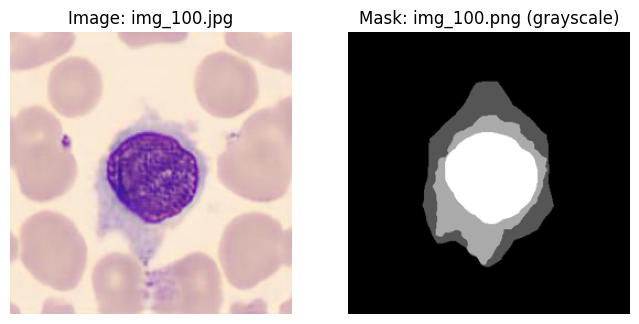

In [ ]:
# Load the image and mask number n
n = 0

# Load the image and mask using PIL
img = Image.open(image_paths[n])
mask = Image.open(mask_paths[n]).convert('L')

# Show the image and mask using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title(f'Image: {os.path.basename(image_paths[n])}')
axs[1].imshow(mask, cmap='gray')
axs[1].axis('off')
axs[1].set_title(f'Mask: {os.path.basename(mask_paths[n])} (grayscale)')
plt.show()

To train a semantic segmentation model you will need the mask to be encoded in one-hot encoding. In this case, since we have 3 active classes, we must convert the original mask of dimensions (H, W) and uint8 values (between 0 and 255) into a mask of dimensions (H, W, C) where C=3 is the number of channels, with uint8 type formats and values equal to 255 in the active pixels and 0 in the others.

So if you run the following cell you should see something like this:

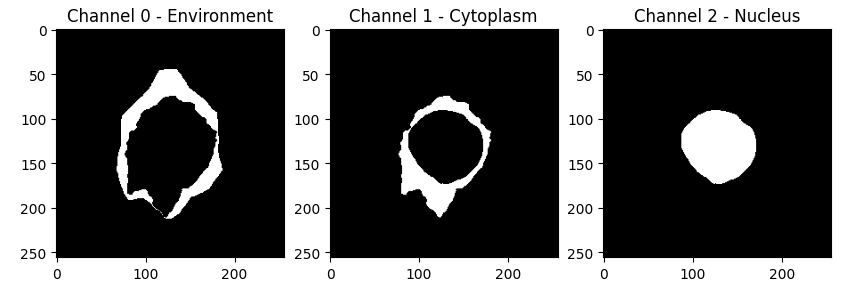

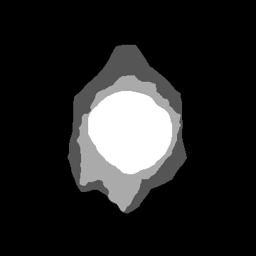

In [ ]:
mask

Due to the quality with which these masks were saved, spurious values appeared on the borders between zones that were not exactly those. This caused issues when creating a 3-channel mask from the grayscale mask, as the code assumed that the pixel values in the grayscale mask would only be the original values. To solve this issue, I followed the recommendation and rounded the pixel values of the grayscale mask to the closest values of 0, 1, 2, or 3 using a transformation.

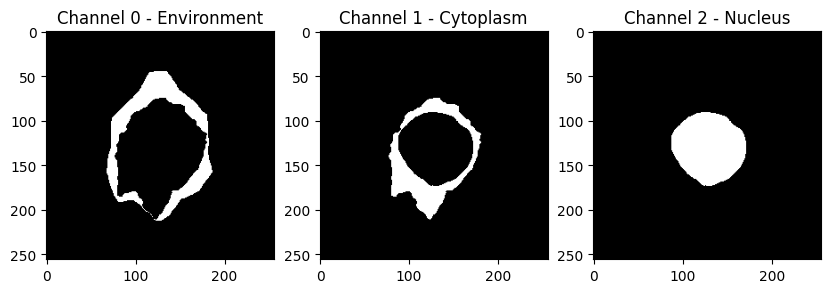

In [ ]:
# TODO: Complete the deep_mask function

# Convert a np mask with a grayscale format (H x W) with value range
# 0-255 (equally spaced; i.e. 2 classes + background would be 0, 127,
# 255) to a numpy mask (H x W x C) with C equal to number of channels
# (classes) with 255 in the active pixels and 0 otherwise (uint8
# format)

# Inputs:
#     mask: (np-array) Grayscale image array of two dimensions (H x W)

# Outputs:
#     output: (np-array) Numpy array with 3 dimensions (H x W x C)

def deep_mask(mask, nlevels):
    # Round the mask to the closest values of 0, 1, 2, or 3
    mask = np.round(mask / (255 / nlevels)).astype(np.uint8)
    
    # Divide the grayscale mask into 4 regions based on pixel values
    nucleus_mask = np.where(mask == 3, 255, 0).astype(np.uint8)
    cyto_mask = np.where(mask == 2, 255, 0).astype(np.uint8)
    env_mask = np.where(mask == 1, 255, 0).astype(np.uint8)
    background_mask = np.where(mask == 0, 255, 0).astype(np.uint8)
    
    # Combine the region masks into a single 3-channel mask
    output = np.stack([env_mask, cyto_mask, nucleus_mask], axis=-1)
    
    return output

# Testing your function. Run this cell when you have defined the funtion
dm = deep_mask(np.array(mask), NUM_CLASS)

# Assert the format
assert dm.dtype == np.uint8, "WARNING - The format should be uint8"

# create a figure with three subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# show each channel as grayscale in a subplot
axs[0].imshow(dm[:, :, 0], cmap='gray')
axs[1].imshow(dm[:, :, 1], cmap='gray')
axs[2].imshow(dm[:, :, 2], cmap='gray')

# set the title of each subplot
axs[0].set_title('Channel 0 - Environment')
axs[1].set_title('Channel 1 - Cytoplasm')
axs[2].set_title('Channel 2 - Nucleus')

# show the plot
plt.show()

Now write a function with the opposite functionality; that is, it receives as input a deepmask of dimensions (H, W, C) with values 255 in the active pixels and 0 in the others (and uint8 format), and returns a numpy array of dimensions (H, W) with equispaced values between 0 and 255 depending on the number of classes.

When executing the next cell you should see the original grayscale mask again, which you have already seen a few cells above; that is, this:

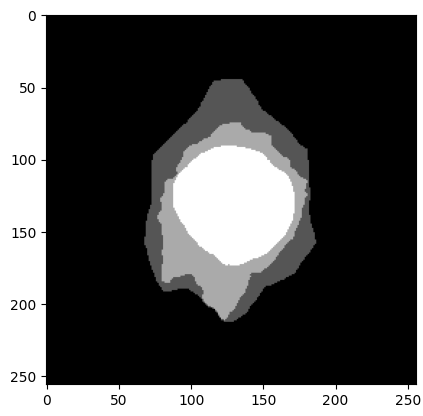

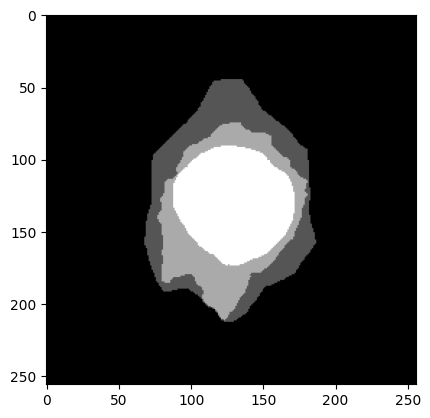

In [ ]:
# TODO: Convert a deep mask into a flat mask.
# Convert a numpy array with dimensions (H x W x C) being C>1 (i.e. multiple
# channels) in a single channel grayscale image numpy array with data type
# uint8 and dimensions (C x W). Deep masks can't be shown in matplotlib, but
# flat masks can.

# Inputs:
#     deep_mask: (numpy array) Numpy array with 3 dimensions (H x W x C)

# Outputs:
#     mask_gray: (np-array) Array of two dimensions (H x W )


def flatten_mask(deep_mask):
    if deep_mask.dtype == np.float32:
        deep_mask = np.uint8(deep_mask * 255)

    gray_values = {
        'Environment': 85,
        'Cytoplasm': 170,
        'Nucleus': 255
    }
    gray_mask = np.zeros(deep_mask.shape[:2], dtype=np.uint8)
    for channel, (label, gray_value) in enumerate(gray_values.items()):
        channel_mask = deep_mask[:, :, channel]
        max_value = np.max(channel_mask)
        min_value = np.min(channel_mask)
        intermediate_value = (max_value + min_value) // 2
        gray_mask[channel_mask > intermediate_value] = gray_value
    return gray_mask


# Check the function
plt.imshow(flatten_mask(dm), cmap='gray')

## Train, validation and test

Ok, now you know how the images should look. Before proceeding to load the dataset, let's randomly divide between train, validation and test.

At the end of next cell we should have six lists of paths. This lists must be sorted in a manner that images and masks correspond to each other.

Remember that you have the variables VALID_SIZE and TEST_SIZE for the proportions of each dataset.

In [ ]:
# TODO: split randomly the data so you end up having the lists of paths
# with the specified proportions

# Train, validation and test split
VALID_SIZE = 0.1
TEST_SIZE = 0.1

# Get the total number of images
num_images = len(image_paths)

# Define the number of images in each dataset
num_valid = int(num_images * VALID_SIZE)
num_test = int(num_images * TEST_SIZE)
num_train = num_images - num_valid - num_test

# Randomly shuffle the list of image paths and mask paths
combined = list(zip(image_paths, mask_paths))
random.shuffle(combined)
image_paths, mask_paths = zip(*combined)

# Train paths
image_train_paths = image_paths[:num_train]
mask_train_paths = mask_paths[:num_train]

# Validation paths
image_valid_paths =  image_paths[num_train:num_train+num_valid]
mask_valid_paths = mask_paths[num_train:num_train+num_valid]

# Test paths
image_test_paths = image_paths[num_train+num_valid:]
mask_test_paths = mask_paths[num_train+num_valid:]

## The dataset class

At this point you should define your own dataset class from the `Dataset` python class.

The defined class has to handle transformations, and be able to work for any number of active classes.

You must define at least the `__init__()`, `__len__()` and `__getitem__()` methods. Also, so that the `__getitem__()` method doesn't get too long, you can define a `__deep_mask__()` method that incorporates the functionality you defined earlier in the `deep_mask()` function.

In [ ]:
# TODO: Complete the class definition

###############################################################################
# The dataset class
###############################################################################

class SegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transformations=None,
                 num_class=2):
        # Store the image and mask filepaths, augmentation transforms and
        # number of classes as object attributes
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transformations
        self.num_class = num_class


    def __len__(self):
        # Return the number of total samples contained in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
      # Grab the image path from the current index
      image_path = self.image_paths[idx]

      # Load the image with PIL as numpy array
      image = np.array(Image.open(image_path))

      # Do these same steps with the mask
      mask_path = self.mask_paths[idx]
      mask = np.array(Image.open(mask_path))

      # Apply albumentations transforms
      if self.transforms:
          transformed = self.transforms(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]

      # Convert flat mask to deep mask (one channel per class)
      mask = self.__deep_mask__(mask)

      # Return a tuple of the image and its mask as tensors
      return (
          to_tensor(image),
          to_tensor(mask),
      )

    def __deep_mask__(self, mask):
        # Convert a flat grayscale mask into a channeled grayscale mask

        # Convert a np mask with a grayscale format (H x W) with value range
        # 0-255 (equally spaced; i.e. 2 classes + background would be 0, 127,
        # 255) to a numpy mask (H x W x C) with C equal to number of channels
        # (classes) with 255 in the active pixels and 0 otherwise (uint8
        # format)

        output = deep_mask(np.array(mask), NUM_CLASS)
        
        return output

Define the transformations you want to perform. Explain as comments on the code itself the reason for these transformations and why not others. In this specific dataset, neither color nor zoom transformations are appropriate because the data conforms to a certain standard.

**HINT: Albumentations**


I use Albumentations, it is an image augmentation library that provides a variety of image transforms. In this specific dataset, neither color nor zoom transformations are appropriate because the data conforms to a certain standard. Instead, we could consider applying some basic geometric transformations to augment the data. For example, we can perform random rotations, flips, and translations to artificially increase the diversity of the dataset.

In [ ]:
# TODO: Define transforms for train/valid/test

import albumentations as A

# Define the transforms for train/valid sets
transform_train = A.Compose([
    #Cropping the center region to remove unnecessary background
    A.CenterCrop(240, 240),
    #Randomly rotates the image by 90 degrees in either clockwise or counterclockwise direction 
    A.RandomRotate90(p=0.3), 
    #Randomly selects between horizontal and vertical flips with 0.3 prob
    A.Flip(p=0.3),
])

# Define the transforms for the test set (only CenterCrop)
transform_test = A.Compose([
     A.CenterCrop(240, 240)
])

Define the datasets

In [ ]:
# Define the three basic datasets
train_set = SegDataset(image_train_paths,
                       mask_train_paths,
                       transform_train,
                       NUM_CLASS)

valid_set = SegDataset(image_valid_paths,
                       mask_valid_paths,
                       transform_test,
                       NUM_CLASS)

test_set = SegDataset(image_test_paths,
                      mask_test_paths,
                      transform_test,
                      NUM_CLASS)

datasets = {'train': train_set, 'valid': valid_set, 'test': test_set}

And now define the dataloaders

In [ ]:
# If you are working locally, feel free to change the num_workers parameter
num_workers = 0
shuffle = True
tbs = 8  # Test batch size
dataloaders = {'train': DataLoader(train_set,
                                   batch_size=batch_size,
                                   shuffle=shuffle,
                                   num_workers=num_workers),
               'valid': DataLoader(valid_set,
                                   batch_size=batch_size,
                                   shuffle=shuffle,
                                   num_workers=num_workers),
               'test': DataLoader(test_set,
                                  batch_size=tbs,
                                  shuffle=False,
                                  num_workers=num_workers)}

Now we're defining a helper function that we'll use in the next cell.

In [ ]:
###############################################################################
# Function: to_npimage
###############################################################################

# Convert a torch tensor image with shape (C x H x W) to numpy array image of
# shape (H x W x C). C stands for channel, H for height and W for width.

# Inputs:
#     tensor_im: (tensor) Torch tensor with 3 dimensions (C x H x W)

# Outputs:
#     - (np-array) Array of three dimensions (H x W x C)


def to_npimage(tensor_im):
    # From tensor with shape (C x H x W) to numpy with shape (H x W x C)
    return tensor_im.numpy().transpose((1, 2, 0))

And now we load the first batch and check the first figure and mask. You just have to execute next cell and check that it works. If you see any error, check your SegDataset objects.

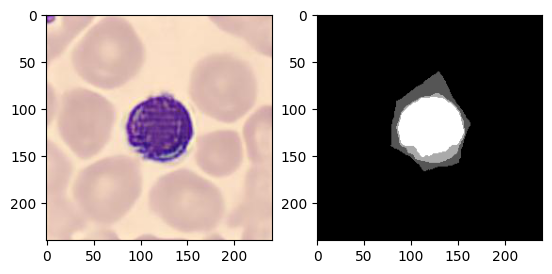

In [ ]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Convert tensor image into numpy and display it in the first subplot
im = to_npimage(inputs[0])
axs[0].imshow(im)

# Convert tensor mask into numpy and display it in the second subplot
msk = flatten_mask(to_npimage(masks[0]))
axs[1].imshow(msk, cmap='gray')

# Show the figure
plt.show()

## Resnet18 UNet example

At this point a complete example of a UNet network will be developed from a ResNet18 encoder. What is done here is exactly what you are going to be asked to do in the next section with a different encoder model, so make sure you understand it perfectly.

This example is coming out of Usuyama's great GitHub repository which you can find here: https://github.com/usuyama/pytorch-unet

As you recall, a convolutional network used as a classifier looks something like the following figure. That is, filters are applied in such a way that the height and width of the image decreases as the depth (features) grows.

<img src="https://drive.google.com/uc?export=view&id=1CJSpntUztXf78hPQI_QkHbuZaEIkdPYI" width=1800>

On the other hand, a UNet network has an initial structure like the one shown below (source: _Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. 2015. U-Net: Convolutional Networks for Biomedical Image Segmentation. Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics). Vol. 9351._ https://doi.org/10.1007/978-3-319-24574-4_28.)

<img src="https://drive.google.com/uc?export=view&id=1fU0c5jfnfylhF9fB9Hj3GYThmuDxvXN5" width=500>


For obvious reasons, since we are going to use a specific encoder, our resulting UNet network will not be identical to the one shown. As said before, the encoder (left part of the UNet network) will be a pre-trained Resnet18 network.

It must be taken into account that the UNet network has skip pathways, so it will be necessary to implement them and balance everything dimensionally on both the encoder and decoder sides.

Let's see how this would be done step by step.



In [ ]:
# Let's load the model for a first inspection
base_model = models.resnet18(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 277MB/s]


In [ ]:
# Let's explore the model. It is a network with multiple convolutional
# layers and a fully connected layer as a classifier.
for ix, block in enumerate(list(base_model.children())):
    print("Block {}:\n{}\n\n".format(ix, block))

Block 0:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


Block 1:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Block 2:
ReLU(inplace=True)


Block 3:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


Block 4:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel

In addition to viewing the model this way, we may want to use the summary statement to see how the dimensions vary.

Be careful, notice that this instruction numbers differently. In this case we can easily see how the dimensions vary; but the outputs are listed by layers (and not by layer blocks). Also, layer blocks start at index 0 (like any list), while layers indicated by the summary statement start at index 1, as shown below.

```python
summary(base_model.to(DEVICE), input_size=(3, 224, 224))
```

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
```

The result tells us that if we give this network an input of
(C=3, H=224, W=224) to layer 1, we will obtain in the output of layer 3 dimensions of (64, 112, 112)

Layers 1, 2, and 3 of the summary correspond to blocks 0, 1, and 2 of the original encoder block list. Check comprehension.

In [ ]:
# Summary of the model
summary(base_model.to(DEVICE), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

These three blocks could therefore be the first step of our encoder; that is to say of the contractive path. Let's see how this step is:
```python
class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        # Base model
        self.base_model = models.resnet18(weights='DEFAULT')
        self.base_layers = list(self.base_model.children())
```

Right now we have in `self.base_layers` all the encoder layer blocks.

As we say, our first step can be made up of the first three blocks of the original Resnet18; that is to say:

```python
        # Forward pass of the first part of the base model.
        # Step 1 = Resnet blocks 0, 1 and 2 = Summary layers 1, 2 and 3
        self.step1 = nn.Sequential(*self.base_layers[:3])
```

In other words, we have defined the part of the UNet network that is seen in the following figure. It is about step 1, which enters 3 channels of depth of 224 x 224, and as output it has 64 channels of depth of dimensions 122 x 122.

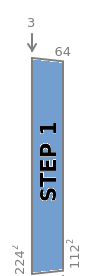

Let's go with the second step. If you follow the encoder blocks one by one, you will see that we can use blocks 3 and 4 as the next step. These two blocks correspond to layers 4 to 18 of the summary.

In this case the input would be (64, 112, 112) and the output would be (64, 56, 56). The way to define this second step would be:

```python
        # Step 2 = Resnet blocks 3 and 4 = Summary layers 4 to 18 (included)
        self.step2 = nn.Sequential(*self.base_layers[3:5])
```

That is, we have defined the following (the steps, not the connections that we'll define in the forward pass):

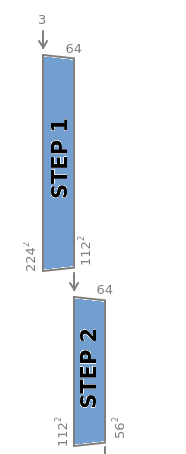

If we continue with this same criterion, we can define the third, fourth and fifth steps as follows:

```python
        self.step3 = self.base_layers[5]  # Block 5 - Summary layers 19...34
        self.step4 = self.base_layers[6]  # Block 6 - Summary layers 35...50
        self.step5 = self.base_layers[7]  # Block 7 - Summary layers 51...66
```

We already have defined the steps that you see in the following image

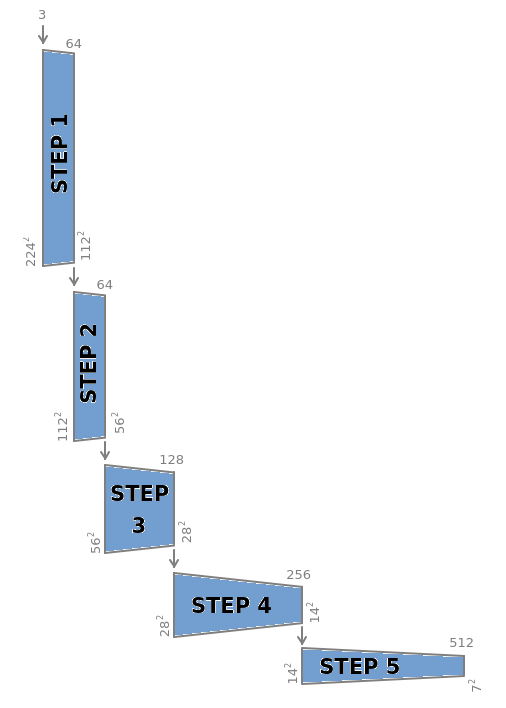

The time has come to define the skip pathways. The skip pathways have the same dimensions at the entrance and at the exit (except for the one that is placed at level 0). In this case we are going to define some skip pathways that incorporate a convolution and a ReLU activation layer.

The way to define the skip pathways, according to the dimensions, is as follows.

```python
        def convrelu(in_channels, out_channels, kernel, padding):
            return nn.Sequential(nn.Conv2d(in_channels,
                                           out_channels,
                                           kernel,
                                           padding=padding),
                                 nn.ReLU(inplace=True))

        # Skip pathways (from encoder levels through decoder levels)
        self.skip1 = convrelu(64, 64, 1, 0)
        self.skip2 = convrelu(64, 64, 1, 0)
        self.skip3 = convrelu(128, 128, 1, 0)
        self.skip4 = convrelu(256, 256, 1, 0)
        self.skip5 = convrelu(512, 512, 1, 0)
        # We will add a skip pathway also at the input level, and not only at
        # the outputs of the steps. This level 0 skip pathway is a little bit
        # more complex
        self.skip0 = nn.Sequential(convrelu(3, 64, 3, 1),
                                   convrelu(64, 64, 3, 1))
```



Now it's time to start with the decoder side (expansive path). First of all we must define the opposite operation (from the dimensional point of view) to the reduction of H and W. We will do this upsample operation in the following way:

https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html

```python
        # Upsample to the upper level
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
```

Next we must define a stage that adapts a tensor to a different dimension; that is, make a depth reduction. Specifically, we will use this block in the expansive path path, once the tensors coming from the skip pathways have been joined with the upsample blocks, to adapt the output to the dimension we select. That is to say:

```python
        # Dimensional adaptation during decoder part (skips + upsamples)
        self.adapt0 = convrelu(64 + 128, 64, 3, 1)
        self.adapt1 = convrelu(64 + 256, 128, 3, 1)
        self.adapt2 = convrelu(64 + 256, 256, 3, 1)
        self.adapt3 = convrelu(128 + 512, 256, 3, 1)
        self.adapt4 = convrelu(256 + 512, 512, 3, 1)
```

Don't worry if you can't figure out where these numbers come from. Continue reading and you will see that everything is explained in the forward pass.

Finally we will need a last component to adapt the output to the number of classes to segmentate.

```python
        # Adaptation to mask classes
        self.mask_classes = nn.Conv2d(64, n_class, 1)
```

With all this, the time has come to define the forward pass. Let's see it step by step.

```python

    def forward(self, input):

        # Forward pass of the original network. The levels are refered to the
        # encoder side
        # level0 = input  # b x 3 x 224 x 224
        level1 = self.step1(input)  # b x 3 x 224 x 224 => b x 64 x 112 x 112
        level2 = self.step2(level1)  # b x 64 x 112 x 112 => b x 64 x 56 x 56
        level3 = self.step3(level2)  # b x 64 x 56 x 56 => b x 128 x 28 x 28
        level4 = self.step4(level3)  # b x 128 x 28 x 28 => b x 256 x 14 x 14
        level5 = self.step5(level4)  # b x 256 x 14 x 14 => b x 512 x 7 x 7
```

Level 0 in the encoder is directly the input, which is why it is commented out. At this point we have the outputs of all levels of the encoder. So we have the tensors at the positions marked with red X of the figure shown below.

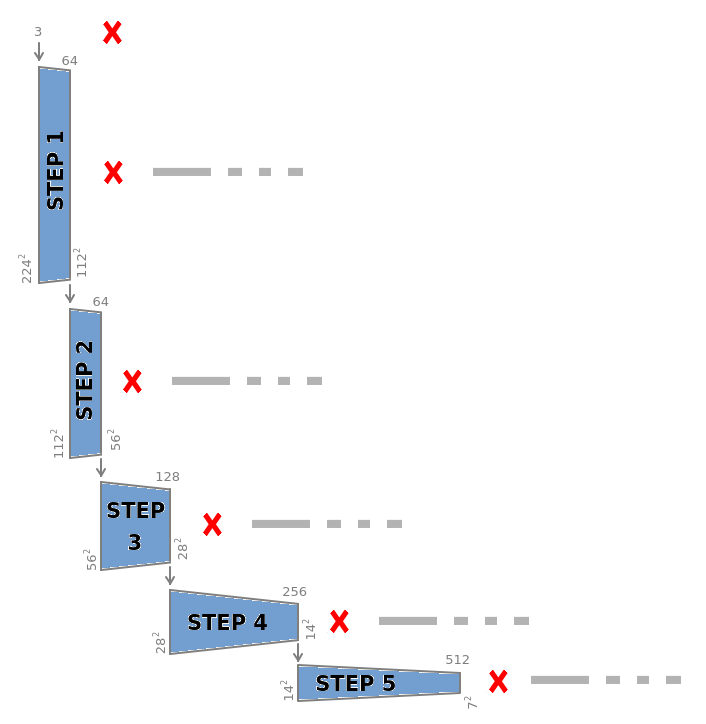

Now we define all the skip pathways. As we know, except in the case of level 0, the dimensions do not change.

```python
        # Skip pathways of the differente levels. Now levels are defined at the
        # decoder side
        level0 = self.skip0(input)   # b x 3 x 224 x 224 => b x 64 x 224 x 224
        level1 = self.skip1(level1)  # b x 64 x 112 x 112 => b x 64 x 112 x 112
        level2 = self.skip2(level2)  # b x 64 x 56 x 56 => b x 64 x 56 x 56
        level3 = self.skip3(level3)  # b x 128 x 28 x 28 => b x 128 x 28 x 28
        level4 = self.skip4(level4)  # b x 256 x 14 x 14 => b x 256 x 14 x 14
        level5 = self.skip5(level5)  # b x 512 x 7 x 7 = > b x 512 x 7 x 7
```

At this point we have defined the behavior of the network in the following figure and we also have the tensors in the positions indicated by the red Xs.

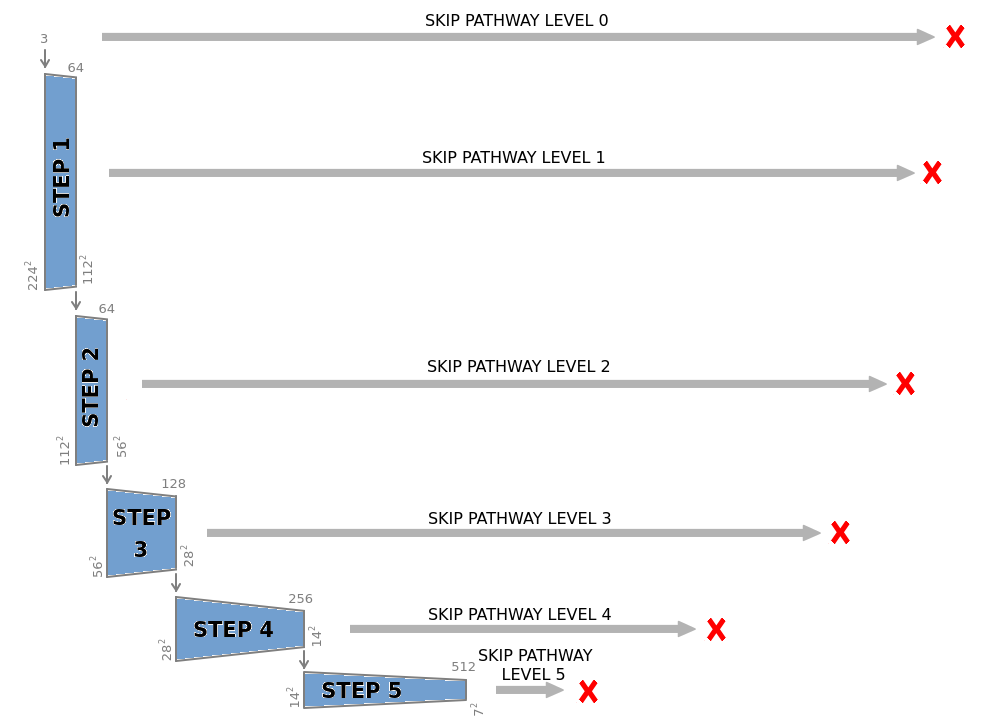

It is time for the most entertaining part. Now you have to start the contraction path. To do this we will make an upsample of each level n, and we will concatenate it with the tensor of level n-1. Since the result is going to have more depth, and we don't want this depth to grow too much, then we will have to adapt the tensor to the appropriate depth with `self.adapt()`.

Let's look at this with level 5:

```python
        # Level 4 - It concatenates upsampled level 5 with the skip pathway
        # of level 4.
        x = self.upsample(level5)  # b x 512 x 7 x 7 => b x 512 x 14 x 14
        x = torch.cat([x, level4], dim=1)  # b x 512 x 14 x 14 + b x 256 x 14 x 14 => b x 768 x 14 x 14
        x = self.adapt4(x)  # b x 768 x 14 x 14 => b x 512 x 14 x 14
```

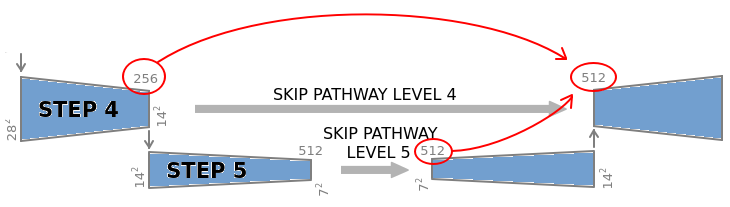

And now you just have to continue maintaining the same criteria at each level.

```python
        # Level 3 - It concatenates upsampled output of the last step with
        # the skip of level 3
        x = self.upsample(x)  # b x 512 x 14 x 14 => b x 512 x 28 x 28
        x = torch.cat([x, level3], dim=1)  # b x 512 x 28 x 28 + b x 128 x 28 x 28 => b x 640 x 28 x 28
        x = self.adapt3(x)  # b x 640 x 28 x 28 => b x 256 x 28 x 28

        # Level 2 - It concatenates upsampled output of the last step with
        # the skip of level 2        
        x = self.upsample(x)  # b x 256 x 28 x 28 => b x 256 x 56 x 56
        x = torch.cat([x, level2], dim=1)  # b x 256 x 56 x 56 + b x 64 x 56 x 56 => b x 320 x 56 x 56
        x = self.adapt2(x)  # b x 320 x 56 x 56 => b x 256 x 56 x 56

        # Level 1 - It concatenates upsampled output of the last step with
        # the skip of level 1
        x = self.upsample(x)  # b x 256 x 56 x 56 => b x 256 x 112 x 112
        x = torch.cat([x, level1], dim=1)  # b x 256 x 112 x 112 + b x 64 x 112 x 112 => b x 320 x 112 x 112
        x = self.adapt1(x)  # b x 320 x 112 x 112 => b x 128 x 112 x 112

        # Level 0 - It concatenates upsampled output of the last step with
        # the skip of level 0
        x = self.upsample(x)  # b x 128 x 112 x 112 => b x 128 x 224 x 224
        x = torch.cat([x, level0], dim=1)  # b x 128 x 224 x 224 + b x 64 x 224 x 224 => b x 192 x 224 x 224
        x = self.adapt0(x)  # b x 192 x 224 x 224 => b x 64 x 224 x 224    
```

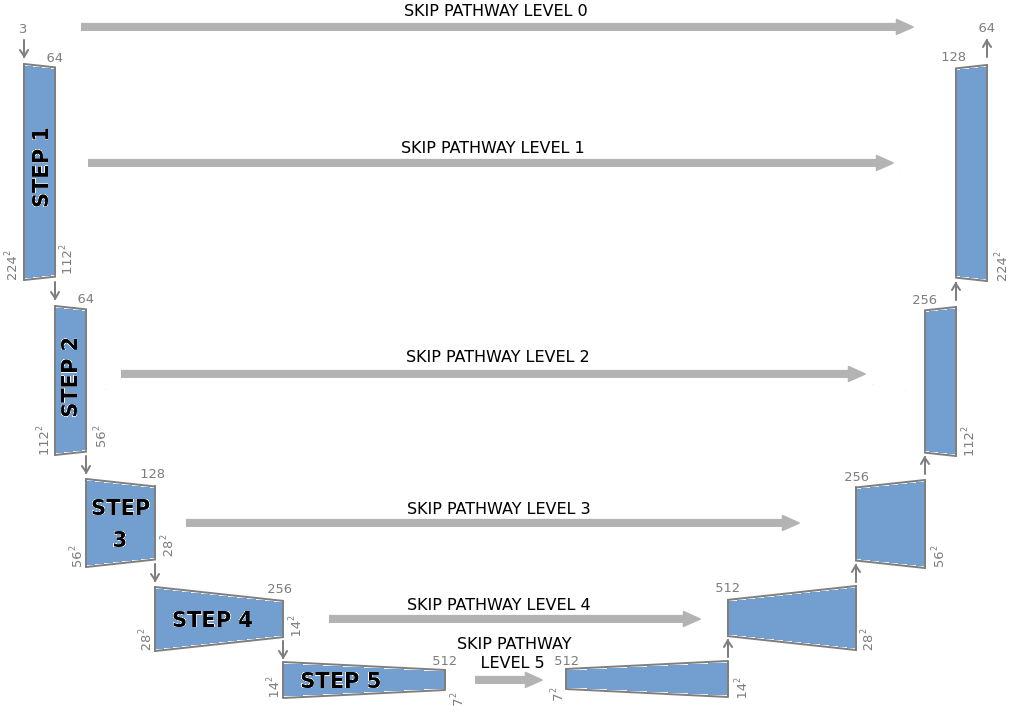

And finally we have the final output of the system, whose number of channels must be adapted to the number of classes that we want to segmentate.

```python
        # Last convolution for adaptation to mask classes
        out = self.mask_classes(x)
```

The full code of this model is given below.

In [ ]:
###############################################################################
# Custom model ResNetUnet
###############################################################################

np.random.seed(SEED)
torch.manual_seed(SEED)

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        def convrelu(in_channels, out_channels, kernel, padding):
            return nn.Sequential(nn.Conv2d(in_channels,
                                           out_channels,
                                           kernel,
                                           padding=padding),
                                 nn.ReLU(inplace=True))

        # Base model
        self.base_model = models.resnet18(weights='DEFAULT')
        self.base_layers = list(self.base_model.children())
        
        # Forward pass of the first part of the base model
        self.step1 = nn.Sequential(*self.base_layers[:3])
        self.step2 = nn.Sequential(*self.base_layers[3:5])
        self.step3 = self.base_layers[5]
        self.step4 = self.base_layers[6]
        self.step5 = self.base_layers[7]

        # Skip pathways (from encoder steps through decoder steps)
        self.skip0 = nn.Sequential(convrelu(3, 64, 3, 1),
                                   convrelu(64, 64, 3, 1))
        self.skip1 = convrelu(64, 64, 1, 0)
        self.skip2 = convrelu(64, 64, 1, 0)
        self.skip3 = convrelu(128, 128, 1, 0)
        self.skip4 = convrelu(256, 256, 1, 0)
        self.skip5 = convrelu(512, 512, 1, 0)
        
        # Upsample to the upper level
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Dimensional adaptation during decoder part (skips + upsamples)
        self.adapt4 = convrelu(256 + 512, 512, 3, 1)
        self.adapt3 = convrelu(128 + 512, 256, 3, 1)
        self.adapt2 = convrelu(64 + 256, 256, 3, 1)
        self.adapt1 = convrelu(64 + 256, 128, 3, 1)
        self.adapt0 = convrelu(64 + 128, 64, 3, 1)
        
        # Adaptation to mask classes
        self.mask_classes = nn.Conv2d(64, n_class, 1)


    def forward(self, input):

        # Forward pass of the original network. The levels are refered to the
        # encoder side
        # level0 = input  # b x 3 x 224 x 224
        level1 = self.step1(input)  # b x 3 x 224 x 224 => b x 64 x 112 x 112
        level2 = self.step2(level1)  # b x 64 x 112 x 112 => b x 64 x 56 x 56
        level3 = self.step3(level2)  # b x 64 x 56 x 56 => b x 128 x 28 x 28
        level4 = self.step4(level3)  # b x 128 x 28 x 28 => b x 256 x 14 x 14
        level5 = self.step5(level4)  # b x 256 x 14 x 14 => b x 512 x 7 x 7

        # Skip pathways of the differente levels. Now levels are defined at the
        # decoder side
        level0 = self.skip0(input)   # b x 3 x 224 x 224 => b x 64 x 224 x 224
        level1 = self.skip1(level1)  # b x 64 x 112 x 112 => b x 64 x 112 x 112
        level2 = self.skip2(level2)  # b x 64 x 56 x 56 => b x 64 x 56 x 56
        level3 = self.skip3(level3)  # b x 128 x 28 x 28 => b x 128 x 28 x 28
        level4 = self.skip4(level4)  # b x 256 x 14 x 14 => b x 256 x 14 x 14
        level5 = self.skip5(level5)  # b x 512 x 7 x 7 = > b x 512 x 7 x 7

        # Level 4 - It concatenates upsampled level 5 with the skip pathway
        # of level 4.
        x = self.upsample(level5)  # b x 512 x 7 x 7 => b x 512 x 14 x 14
        x = torch.cat([x, level4], dim=1)  # b x 512 x 14 x 14 + b x 256 x 14 x 14 => b x 768 x 14 x 14
        x = self.adapt4(x)  # b x 768 x 14 x 14 => b x 512 x 14 x 14
 
        # Level 3 - It concatenates upsampled output of the last step with
        # the skip of level 3
        x = self.upsample(x)
        x = torch.cat([x, level3], dim=1)
        x = self.adapt3(x)

        # Level 2 - It concatenates upsampled output of the last step with
        # the skip of level 2        
        x = self.upsample(x)
        x = torch.cat([x, level2], dim=1)
        x = self.adapt2(x)

        # Level 1 - It concatenates upsampled output of the last step with
        # the skip of level 1
        x = self.upsample(x)
        x = torch.cat([x, level1], dim=1)
        x = self.adapt1(x)

        # Level 0 - It concatenates upsampled output of the last step with
        # the skip of level 0
        x = self.upsample(x)
        x = torch.cat([x, level0], dim=1)
        x = self.adapt0(x)        
        
        # Last convolution for adaptation to mask classes
        out = self.mask_classes(x)        
        
        return out

## Helper functions

Next, a series of functions are provided that will help you to continue with the practice. Specifically, functions that have already been seen in previous practices are provided, such as the training function, or the functions to record the best trained model. Other functions for the calculation of the Dice coefficient and other improvements are also provided; however, you don't have to do anything with them except use them.

In fact, after consulting them, you can hide this section and continue with the practice. Have a look to these functions if you need further details of what they do.

In [ ]:
###############################################################################
# Function: select_model
###############################################################################

# Load pretrained segmentation model from segmentation_models_pytorch and set
# some training parameters from optimizer and scheduler.

# MODEL OPTIONS
# 1 - ResnetUnet
# 2 - VGG16Unet

# Inputs:
#     option: (integer) Select the model number from the list above
#     num_class: (integer) Number of active classes in segmentation
# Outputs:
#     model: (torch model) Pretrained model without freezing any layer
#     arch: (string) Architecture name
#     encoder_name: (string) Encoder name
#     optimizer: (optimizer) Optimizer object
#     scheduler: (scheduler) Scheduler object

def select_model(option=1, num_class=3):

    if option == 1:
        arch = "ResNetUnet"
        encoder_name = ""
        encoder_weights = 'imagenet'
        in_channels = 3
        out_channels = num_class

        model = ResNetUNet(NUM_CLASS).to(DEVICE)

        optimizer = optim.Adam(filter(lambda param: param.requires_grad,
                                      model.parameters()), lr=0.0001)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    elif option == 2:
        arch = "VGG16UNet"
        encoder_name = ""
        encoder_weights = 'imagenet'
        in_channels = 3
        out_channels = num_class

        model = VGG16UNet(NUM_CLASS).to(DEVICE)

        optimizer = optim.Adam(filter(lambda param: param.requires_grad,
                                      model.parameters()), lr=0.0001)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    return model, arch, encoder_name, optimizer, scheduler

In [ ]:
###############################################################################
# Function: save_tr_model
###############################################################################

# Save trained model
# Save all the basic training model data (state_dict of model, optimizer and
# scheduler). It alsa saves the training_log and the local time.

# Inputs:
#     model: (torch model) The trained model.
#     optimizer: (optimizer) The optimizer object.
#     scheduler: (scheduler) The scheduler.
#     training_log: (list) Training log as created in 'train_model' function.
#     filename: (string) Name of the file to save the data.

# Outputs:
#     None - The file is saved in the current folder

def save_tr_model(model, optimizer, scheduler, training_log,
                  filename='model.pth', *args, **kwargs):
    model.to('cpu')
    custom_dict = {'model_state_dict': model.state_dict(),
                   'opt_state_dict': optimizer.state_dict(),
                   'sche_state_dict': scheduler.state_dict(),
                   'training_log': training_log,
                   'time': time.localtime()}

    torch.save(custom_dict, filename)
    model.to(DEVICE)

In [ ]:
###############################################################################
# Function: dice_loss_fcn
###############################################################################

# Dice loss function
# Return loss function as the inverse of dice coefficient. Dice coefficient
# goes from 0 to 1, being 1 the best possible result and 0 the worst. This
# function, as a loss function, returns a value that is better as the loss is
# closer to 0. The output is calculated as 1 - dice_coefficient


# Inputs:
#     pred: (torch tensor) Predicted mask of shape (C x H x W)
#     target: (torch tensor) Target mask of same shape
#     smooth: (float) Smooth coefficient to avoid division by 0
#     layers_from: (integer) First layer (channel) to take into account in
#           the calculation of the Dice coefficient. Default is 0.

# Outputs:
#     - (float) Number between 0 and 1. Calculated as (1 - dice coefficient)


def dice_loss_fcn(pred, target, smooth=1.0, layers_from=0):

    # Convert tensors as contiguous and drop any layer if required
    pred = pred.contiguous()[:, layers_from:, :, :]
    target = target.contiguous()[:, layers_from:, :, :]

    # Calculate intersection
    inter = (pred * target).sum(dim=2).sum(dim=2)

    # Calculate sum of areas
    area_sum = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2)

    # Calculate dice coefficient
    dice = ((2. * inter + smooth) / (area_sum + smooth)).mean()

    # Return loss
    return 1 - dice

In [ ]:
###############################################################################
# Function: loss_fcn
###############################################################################

# Custom loss function
# This function integrates both custom 'dice_loss_fcn' (see above) and standard
# Binary Cross Entropy Loss in one single loss function. By default the weight
# of each one is 0.5, but it can be modified.
# It also record the metrics, adding them up to the current ones.

# Inputs:
#     pred: (torch tensor) Predicted mask of shape (C x H x W)
#     target: (torch tensor) Target mask of same shape
#     metrics: (defaultdict) Dictionary. The key is a metric name and the
#         value is the current accumulated metric value (added in each batch)
#     w: (float) Weight. Ratio assigned to Binary Cross Entropy Loss. Range 0-1
#     mode: (string) It's just a label for the keys of metrics dict. It's
#         necessary to identify if the current metrics are from training or
#         from validation. Default: 'train'
#     lf: (integer) Layers from which the Dice coefficient is calculated

# Outputs:
#     loss: (float) Loss
#     metrics: (defaultdict) Updated metrics with the current batch metric
#         added.


def loss_fcn(pred, target, metrics, w=0.5, mode='train', lf=0):
    # w: weight of the binary cross entropy in the combined loss

    # Standard loss function
    bce = F.binary_cross_entropy_with_logits(pred, target)

    # Calculate prediction for dice comparison
    pred = torch.sigmoid(pred)

    # Dice metric loss
    smooth = 1.0 if mode == 'train' else 0.0
    dice_loss = dice_loss_fcn(pred, target, smooth=smooth, layers_from=lf)

    # Dice metric through torchmetrics
    # dice = dice_fcn(pred, target.type('torch.ShortTensor').to(DEVICE))

    # Combine both losses
    loss = bce * w + dice_loss * (1 - w)

    # Record accumulated metrics of the current epoch
    metrics[mode + '_bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics[mode + '_dice'] += dice_loss.data.cpu().numpy() * target.size(0)
    metrics[mode + '_loss'] += loss.data.cpu().numpy() * target.size(0)
    metrics[mode + '_epoch_samples'] += target.size(0)

    return loss, metrics

In [ ]:
###############################################################################
# Function: update_metrics
###############################################################################

# Update metrics at the end of one epoch. Transforms the sum of batch metrics
# in epoch metric.
# Metrics are calculated and added up in every batch. At the end of all the
# batches of an epoch, the metric epoch value has to be calculated through the
# mean of all the batch metrics. This is done in this function.

# See an important detail: metrics is a dict that has some keys that end with
# the string 'dice'. These items have a value that corresponds with dice loss
# at the input, but their value at the output is the dice coefficient.

# Inputs:
#     metrics: (defaultdict) Dictionary. The key is a metric name and the
#         value is the current accumulated metric value (the sum of all the
#         batches.

# Outputs:
#     metrics: (defaultdict) Updated metrics with the current epoch metrics.


def update_metrics(metrics):
    # Get the number os samples of train and validation or test
    train_epoch_samples = metrics['train_epoch_samples']
    valid_epoch_samples = metrics['valid_epoch_samples']
    test_epoch_samples = metrics['test_epoch_samples']

    # Delete these data from the metrics dictionary
    metrics.pop('train_epoch_samples')
    metrics.pop('valid_epoch_samples')
    metrics.pop('test_epoch_samples')

    # Calculate the average metrics of all the batches; i.e. the epoch metrics
    for m in metrics.keys():
        if m.startswith('train'):
            metrics[m] /= train_epoch_samples
        elif m.startswith('valid'):
            metrics[m] /= valid_epoch_samples
        elif m.startswith('test'):
            metrics[m] /= test_epoch_samples

        # If the metric is the dice loss, it needs to be inverted to calculate
        # the dice coefficient (i.e. 1 - dice_loss)
        if m.endswith('_dice'):
            metrics[m] = 1 - metrics[m]

    return metrics

In [ ]:
###############################################################################
# Function: print_metrics
###############################################################################

# Helper function to print some results during training

# Inputs:
#     metrics: (defaultdict) Dictionary with metrics

# Outputs:
#     None. It displays training info.

def print_metrics(metrics, minimum=False):
    outputs = []

    if minimum:
        outputs.append("Tr loss: {:.4f} - Val loss: {:.4f} - Time: {:.1f}".format(
            metrics['train_loss'], metrics['valid_loss'], metrics['time']))
    else:
        for m in metrics.keys():
            outputs.append("{}: {:.4f}".format(m, metrics[m]))

    print("Epoch summary: {}".format(" - ".join(outputs)))

In [ ]:
###############################################################################
# Function: train_model
###############################################################################

# Training loop

# Inputs:
#     model: (torch model) The model to be trained
#     optimizer: (optimizer) The optimizer object.
#     scheduler: (scheduler) The scheduler.
#     loaders: (dict) Dictionary with at least to items: loaders['train] and
#         loaders['valid'], contenining its corresponding dataloader.
#     num_epochs: (integer) Number of epochs to train
#     checkpoint: Optional. A checkpoint object as saved by the save_tr_model
#         function
#     verbose: (integer) Code to control the displayed info. 0: No info.
#     lf (integer): Layers from which the dice coefficient will be calculated.
#         Default is 0, menaing all layers will be used.

# Outputs:
#     model: (torch model) Trained model
#     training_log: (list) List of metrics in each epoch. Metrics is a dict.


def train_model(model, optimizer, scheduler, loaders, num_epochs=25,
                checkpoint={}, verbose=0, lf=0):

    # Training data retrieval if applicable
    if bool(checkpoint):
        training_log = checkpoint['training_log']
        valid_loss_min = np.min([x['valid_loss'] for x in training_log])
        trained_epochs = len(checkpoint['training_log'])
        best_state_dict = copy.deepcopy(model.state_dict())
    else:
        training_log = []
        valid_loss_min = np.Inf
        trained_epochs = 0
        best_state_dict = {}

    # Loop through epochs
    for epoch in range(1 + trained_epochs, 1 + trained_epochs + num_epochs):

        # Initialization of variables of the current epoch
        start_time = time.time()
        metrics = defaultdict(float)
        if verbose > 0:
            print(f"\nEpoch {epoch}")
            print("---------")

        # TRAINING
        model.train()

        # Loop in batches through the training data
        for inputs, labels in loaders['train']:
            # Tensors to gpu
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            # Reset gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Calculate batch loss and update the metrics
            loss, metrics = loss_fcn(outputs, labels, metrics, mode='train',
                                     lf=lf)
            # Compute backpropagation
            loss.backward()
            # Update optimizer weights
            optimizer.step()

        # Apply new learning rate
        scheduler.step()

        # VALIDATION
        model.eval()

        # Loop in batches through the validation data
        for inputs, labels in loaders['valid']:
            # Tensors to gpu
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            # Forward pass without gradients
            with torch.no_grad(): outputs = model(inputs)
            # Calculate batch loss and update the metrics
            loss, metrics = loss_fcn(outputs, labels, metrics, mode='valid',
                                     lf=lf)

        # METRICS
        # Record time
        metrics['time'] = time.time() - start_time
        # Update metrics (calculate metrics per epoch)
        metrics = update_metrics(metrics)
        # Print metrics of the current epoch
        if verbose > 0:
            print_metrics(metrics, minimum=False)
        # Record metrics in training log
        training_log.append(metrics)

        # MODEL SAVE
        if metrics['valid_loss'] < valid_loss_min:
            if verbose > 0:
                print("saving best model")
            valid_loss_min = metrics['valid_loss']
            save_tr_model(model, optimizer, scheduler, training_log)
            best_state_dict = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_state_dict)
    return model, training_log

In [ ]:
###############################################################################
# Function: plot_training_log
###############################################################################

# Helper function to plot the training log

# Inputs:
#     tr_log: (list) The training log is a list of metrics. Each item if the
#         list is a dict of the metrics of that epoch. The dict contains at
#         least the keys 'train_loss', 'valid_loss', 'train_dice' and
#         'valid_dice'

# Outputs:
#     None - It displays the plot


def plot_training_log(tr_log):
    losses = np.array([[m['train_loss'], m['valid_loss']] for m in tr_log])
    tr_losses, vl_losses = losses[:, 0], losses[:, 1]
    x = range(1, 1 + len(losses))
    tr_max, tr_min = np.max(tr_losses), np.min(tr_losses)
    epoch_min = 1 + np.argmin(vl_losses)
    val_min = np.min(vl_losses)

    metrics = np.array([[m['train_dice'], m['valid_dice']] for m in tr_log])
    tr_dice, vl_dice = metrics[:, 0], metrics[:, 1]
    # trm_max, trm_min = np.max(tr_dice), np.min(tr_dice)
    epoch_m_max = 1 + np.argmax(vl_dice)
    dice_max = np.max(vl_dice)

    plt.style.use("classic")
    fig = plt.figure(figsize=(14, 5))
    plt.suptitle('Training log', fontsize=16)

    # Subplot 1 - Losses
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('Losses')
    ax1.plot(x, tr_losses, label='training loss')
    ax1.plot(x, vl_losses, label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    ax1.legend()
    ax1.annotate('valid min: {:.4f}'.format(val_min), xy=(epoch_min, val_min),
                 xytext=(round(0.5 * len(tr_losses)), 3*(tr_max - tr_min)/4 +
                         tr_min), arrowprops=dict(facecolor='black',
                                                  shrink=0.05))
    plt.xlim(0, len(tr_losses))

    # Subplot 2 - Metric
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('Dice metric')
    ax2.plot(x, tr_dice, label='training dice')
    ax2.plot(x, vl_dice, label='validation dice')
    plt.xlabel('epochs')
    plt.ylabel('dice metric')
    ax2.legend(loc='lower right')
    ax2.annotate('max dice: {:.4f}'.format(dice_max), xy=(epoch_m_max, dice_max),
                 xytext=(round(0.5 * len(tr_losses)), 0.5 +
                         tr_min), arrowprops=dict(facecolor='black',
                                                  shrink=0.05))
    plt.xlim(0, len(tr_losses))
    plt.ylim(0, 1)

In [ ]:
###############################################################################
# Function: show_compare
###############################################################################

# Helper function to show the original image, the original mask and the
# predicted mask

# Inputs:
#     img: (np-array) Original image as numpy array
#     mask: (np-array) Original (flat) mask as numpy array
#     pred: (np-array) Predicted (flat) mask as numpy array

# Outputs:
#     None - It displays the plot


# Helper function to show the image, the mask and the predicted mask
def show_compare(img, mask, pred):
    # plt.style.use("ggplot")
    plt.style.use("classic")
    fig = plt.figure(figsize=(14, 5))
    plt.suptitle('Image, mask and prediction', fontsize=16)

    # Subplot 1 - Image
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Image')
    plt.imshow(img)

    # Subplot 2 - Mask
    ax1 = fig.add_subplot(1, 3, 2)
    ax1.set_title('Mask')
    plt.imshow(mask, cmap='gray')

    # Subplot 3 - Prediction
    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('Prediction')
    plt.imshow(pred, cmap='gray')

    plt.show()

In [ ]:
###############################################################################
# Function: do_test
###############################################################################

# Helper function to run the model with test images and extract the bundled
# metrics of the test data.

# Inputs:
#     loader: (dataloader) Test dataloader
#     model: (model) Trained model

# Outputs:
#     metrics: (dict) Dictionary with metrics


def do_test(loader, model, lf=0):

    # Prepare model and parameters
    model.eval()
    model.to(DEVICE)
    metrics = defaultdict(float)

    # Loop in batches through the test data
    for inputs, labels in loader:
        # Tensors to gpu
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        # Forward pass without gradients
        with torch.no_grad():
            outputs = model(inputs)
        # Calculate batch loss and update the accumulated metrics
        _, metrics = loss_fcn(outputs, labels, metrics, mode='test', lf=lf)

    # Update metrics (calculate bundled metrics)
    metrics = update_metrics(metrics)

    return metrics

## Define your UNet model with a VGG16 encoder

Define your UNet network with a VGG16 encoder, similar to what has been done with the ResNet18. Remember that the goal is to have a performance similar to that defined as an example. Implement 5 steps and 6 skip pathways. Choose the layers that conform each step and the dimensions carefully; they do not have to be necessarily the same as the example, since the layers of a VGG16 are not the same as those of a Resnet18.

If you do not want to define the model at this time, go to the next point and you will be able to train with the ResNet18 model, thus checking that everything works correctly.

In [ ]:
# Load the model
base_model = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 92.2MB/s]


In [ ]:
# Explore the model
for ix, block in enumerate(list(base_model.children())):
    print("Block {}:\n{}\n\n".format(ix, block))

Block 0:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, 

In [ ]:
# See the summary
summary(base_model.to(DEVICE), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Here's a step-by-step breakdown:

1-The code initializes the random seed for reproducibility purposes.

2-The __init__ method of the VGG16UNet class is defined. This method is responsible for initializing the model and its parameters. It takes the number of output classes (n_class) as an input.

3-Inside the __init__ method, the VGG16 base model is loaded using models.vgg16(weights='DEFAULT'). The weights argument indicates that the default pre-trained weights for the VGG16 model should be used.

4-The layers of the VGG16 model are extracted using self.base_layers = list(self.base_model.children()).

5-The code defines five encoder steps (self.step1, self.step2, self.step3, self.step4, self.step5) by selecting specific ranges of layers from the VGG16 model. These encoder steps correspond to the convolutional layers of the VGG16 model.

6-Skip pathways are defined to connect the encoder and decoder steps. These skip pathways allow the model to transfer low-level feature maps from the encoder to the decoder. The skip pathways are implemented as convolutional layers with ReLU activation functions (convrelu function).

7-An upsampling layer (self.upsample) is defined to increase the spatial resolution of feature maps during the decoding process. It uses bilinear interpolation for upsampling.

8-Dimensional adaptation layers are defined (self.adapt4, self.adapt3, self.adapt2, self.adapt1, self.adapt0) to adjust the dimensions of feature maps during the decoding process. These layers concatenate the upsampled feature maps from the previous step with the corresponding skip pathway feature maps.

9-Final convolutional layer (self.mask_classes) is defined to adapt the feature maps to the number of output classes.

10-The forward method of the VGG16UNet class is defined. This method implements the forward pass of the model. It takes an input tensor and passes it through the defined layers in the specified order.

11-The forward pass starts with the input tensor (input) and goes through the encoder steps (self.step1 to self.step5) to obtain the intermediate feature maps at different levels.

12-The skip pathways are applied by passing the input tensor through the corresponding skip layers.

13-The feature maps from the encoder steps and skip pathways are combined through upsampling and concatenation operations in the decoder steps. The dimensional adaptation layers (self.adapt4 to self.adapt0) are applied to adjust the dimensions of the concatenated feature maps.

14-Finally, the adapted feature maps are passed through the last convolutional layer (self.mask_classes) to obtain the output predictions. The shape of the output tensor is (batch_size, n_class, 224, 224), where batch_size is the number of input samples and n_class is the number of output classes.

15-The output tensor is returned as the final output of the forward pass.

The custom model combines the features of the VGG16 model with the U-Net architecture to perform semantic segmentation tasks, where the goal is to classify each pixel in an image into different classes among Nucleus, Cytoplasm and Environment.

In [ ]:
# TODO: Define the model VGG16UNet

###############################################################################
# Custom model VGG16UNet
###############################################################################

np.random.seed(SEED)
torch.manual_seed(SEED)
    
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True))
    
class VGG16UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        # Base model
        self.base_model = models.vgg16(weights='DEFAULT')              
        self.base_layers = list(self.base_model.children())
        
        # Encoder steps: Forward pass of the first part of the base model
        self.step1 = nn.Sequential(*self.base_layers[0][:4])
        self.step2 = nn.Sequential(*self.base_layers[0][4:9])
        self.step3 = nn.Sequential(*self.base_layers[0][9:16])
        self.step4 = nn.Sequential(*self.base_layers[0][16:23])
        self.step5 = nn.Sequential(*self.base_layers[0][23:30])

        # Skip pathways (from encoder steps through decoder steps)
        self.skip0 = nn.Sequential(convrelu(3, 64, 3, 1),
                                   convrelu(64, 64, 3, 1))
        self.skip1 = convrelu(64, 64, 1, 0)
        self.skip2 = convrelu(128, 128, 1, 0)
        self.skip3 = convrelu(256, 256, 1, 0)
        self.skip4 = convrelu(512, 512, 1, 0)
        self.skip5 = convrelu(512, 512, 1, 0)
        
        # Upsample to the upper level
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Dimensional adaptation during decoder part (skips + upsamples)
        self.adapt4 = convrelu(512 + 512, 512, 3, 1)
        self.adapt3 = convrelu(256 + 512, 512, 3, 1)
        self.adapt2 = convrelu(128 + 512, 256, 3, 1)
        self.adapt1 = convrelu(64 + 256, 128, 3, 1)
        self.adapt0 = convrelu(64 + 128, 64, 3, 1)
        
        # Adaptation to mask classes
        self.mask_classes = nn.Conv2d(64, n_class, 1)

    def forward(self, input):

        # Forward pass of the original network. The levels are refered to the
        # encoder side
        # level0 = input  # b x 3 x 224 x 224
        level1 = self.step1(input)  # b x 64 x 224 x 224
        level2 = self.step2(level1)  # b x 128 x 112 x 112
        level3 = self.step3(level2)  # b x 256 x 56 x 56
        level4 = self.step4(level3)  # b x 512 x 28 x 28
        level5 = self.step5(level4)  # b x 512 x 14 x 14

        # Skip pathways of the differente levels. Now levels are defined at the
        # decoder side
        level0 = self.skip0(input)  # b x 64 x 224 x 224
        level1 = self.skip1(level1)  # b x 64 x 112 x 112
        level2 = self.skip2(level2)  # b x 64 x 56 x 56
        level3 = self.skip3(level3)  # b x 128 x 28 x 28
        level4 = self.skip4(level4)  # b x 256 x 14 x 14
        level5 = self.skip5(level5)  # b x 512 x 7 x 7

        # Level 4 - It concatenates upsampled level 5 with the skip pathway
        # of level 4.
        x = self.upsample(level5)  # b x 512 x 14 x 14
        x = torch.cat([x, level4], dim=1)  # b x 768 x 14 x 14
        x = self.adapt4(x)  # b x 512 x 14 x 14

 
        # Level 3 - It concatenates upsampled output of the last step with
        # the skip of level 3
        x = self.upsample(x)  # b x 512 x 28 x 28
        x = torch.cat([x, level3], dim=1)  # b x 640 x 28 x 28
        x = self.adapt3(x)  # b x 256 x 28 x 28

        # Level 2 - It concatenates upsampled output of the last step with
        # the skip of level 2        
        x = self.upsample(x)  # b x 256 x 56 x 56
        x = torch.cat([x, level2], dim=1)  # b x 320 x 56 x 56
        x = self.adapt2(x)  # b x 256 x 56 x 56

        # Level 1 - It concatenates upsampled output of the last step with
        # the skip of level 1
        x = self.upsample(x)  # b x 256 x 112 x 112
        x = torch.cat([x, level1], dim=1)  # b x 320 x 112 x 112
        x = self.adapt1(x)  # b x 128 x 112 x 112

        # Level 0 - It concatenates upsampled output of the last step with
        # the skip of level 0
        x = torch.cat([x, level0], dim=1)  # b x 192 x 224 x 224
        x = self.adapt0(x)  # b x 64 x 224 x 224
        
        # Last convolution for adaptation to mask classes
        out = self.mask_classes(x)  # b x n_class x 224 x 224

        return out   
       

The VGG16UNet model consists of the following components:

1- The VGG16 model is used as the encoder in the contracting path. It is pretrained on the ImageNet dataset and its weights are frozen during training. The encoder consists of five blocks of convolutional layers, followed by max pooling and a dropout layer.

2- The decoder is used in the expansive path, which consists of five blocks of convolutional layers, followed by upsampling and concatenation with the corresponding feature maps from the contracting path. The output of each block is fed into the next block until the final segmentation map is produced.

3- The skip connections are used to connect the feature maps from the contracting path to the corresponding feature maps in the expansive path. These skip connections allow the decoder to use the high-level features from the contracting path to produce accurate segmentation maps.

4- The final layer of the model is a 1x1 convolutional layer that produces the segmentation map. This layer is applied to the output of the last block in the decoder, which represents the highest resolution feature maps in the expansive path. The 1x1 convolutional layer performs a linear transformation to map the features to the desired number of segmentation classes, resulting in the final output segmentation map.

## Model selection and training

In the next cell, set the `m_option` variable to 1 or 2 depending on whether you want to train with the supplied ResnetUnet model, or whether you want to test the VGG16Unet model that you have defined.

Notice that in the next cell, by changing lines 13 and 14, you will also be able to load a model that you have previously trained.

In [ ]:
# MODEL OPTIONS
# 1 - ResnetUnet
# 2 - VGG16Unet

m_option = 2

# Load the model
model, arch, encoder_name, optimizer, scheduler = select_model(m_option,
                                                               NUM_CLASS)
# Tweak hiperparameters of optimizer and scheduler now if desired

# Check if a saved model is requiered
LOAD_TRAINED = False
FILENAME = 'model.pth' if not LOAD_TRAINED else 'resnetunet.pth'

if LOAD_TRAINED:
    # Customize it as desired!!!!

    # Load the parameters that you want. Take into account that by default
    # the statedict of the optimizer and scheduler are pre-loaded, and
    # this could be different than what you expect.

    # Load checkpoint (the dict saved by 'save_tr_model')
    checkpoint = torch.load(FILENAME, map_location=torch.device('cpu'))

    # Pass the current model to cpu
    model = model.to('cpu')

    # Load the state_dict of the model
    model.load_state_dict(checkpoint['model_state_dict'])

    # Pass the model to DEVICE
    model = model.to(DEVICE)

    # Load state_dict of the optimizador and scheduler
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    scheduler.load_state_dict(checkpoint['sche_state_dict'])

    # Load the training log
    training_log = checkpoint['training_log']

    # Display data about the model loaded
    tsav = checkpoint['time']
    print('Saved on year: {}, month: {}, day:{}, time: {}:{}'.format(
        tsav.tm_year, tsav.tm_mon, tsav.tm_mday, tsav.tm_hour, tsav.tm_min))

In [ ]:
# Do the training. 35 epochs is ok, but feel free to change it
if not LOAD_TRAINED:
    n_epochs = 35
    model, training_log = train_model(model=model,
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      loaders=dataloaders,
                                      num_epochs=n_epochs,
                                      checkpoint={},
                                      verbose=1,
                                      lf=1)


Epoch 1
---------
Epoch summary: train_bce: 0.0854 - train_dice: 0.7416 - train_loss: 0.1719 - valid_bce: 0.0328 - valid_dice: 0.9292 - valid_loss: 0.0518 - time: 1226.7767
saving best model

Epoch 2
---------
Epoch summary: train_bce: 0.0267 - train_dice: 0.9338 - train_loss: 0.0465 - valid_bce: 0.0246 - valid_dice: 0.9423 - valid_loss: 0.0411 - time: 79.4486
saving best model

Epoch 3
---------
Epoch summary: train_bce: 0.0217 - train_dice: 0.9460 - train_loss: 0.0379 - valid_bce: 0.0222 - valid_dice: 0.9468 - valid_loss: 0.0377 - time: 79.3423
saving best model

Epoch 4
---------
Epoch summary: train_bce: 0.0201 - train_dice: 0.9505 - train_loss: 0.0348 - valid_bce: 0.0203 - valid_dice: 0.9480 - valid_loss: 0.0361 - time: 79.4511
saving best model

Epoch 5
---------
Epoch summary: train_bce: 0.0195 - train_dice: 0.9508 - train_loss: 0.0344 - valid_bce: 0.0235 - valid_dice: 0.9403 - valid_loss: 0.0416 - time: 79.7323

Epoch 6
---------
Epoch summary: train_bce: 0.0186 - train_dice: 

## Results

### Graphical results

Let's see the training plot and the values of the dice coefficient.

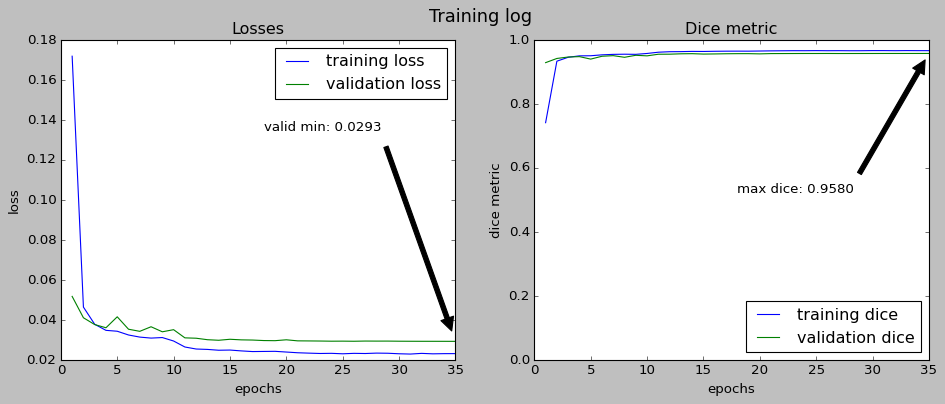

In [ ]:
###############################################################################
# See some results
###############################################################################

# Plot training log
plot_training_log(training_log)

# Get a test batch
model.to('cpu')
model.eval()
inputs, masks = next(iter(dataloaders['test']))
# inputs = inputs.to(DEVICE)
# masks = masks.to(DEVICE)

# Predict
pred = model(inputs)
pred = torch.sigmoid(pred)

# Leave everything at cpu
inputs, masks, pred = inputs.cpu(), masks.cpu(), pred.cpu()

In the next cell, a loop is made through the first batch of the test dataset. Complete the code so that I can see a comparison between the original mask and the predicted one. You should be able to see 8 images like the one below.

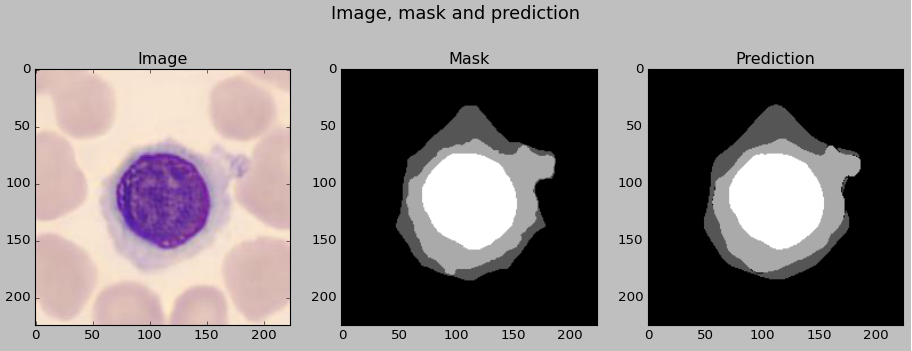

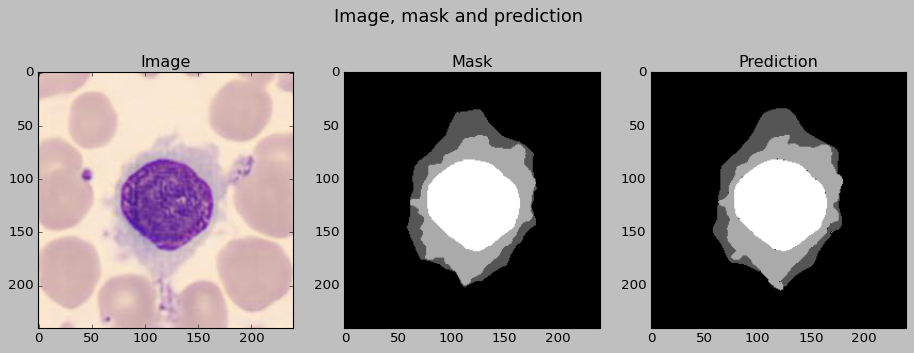

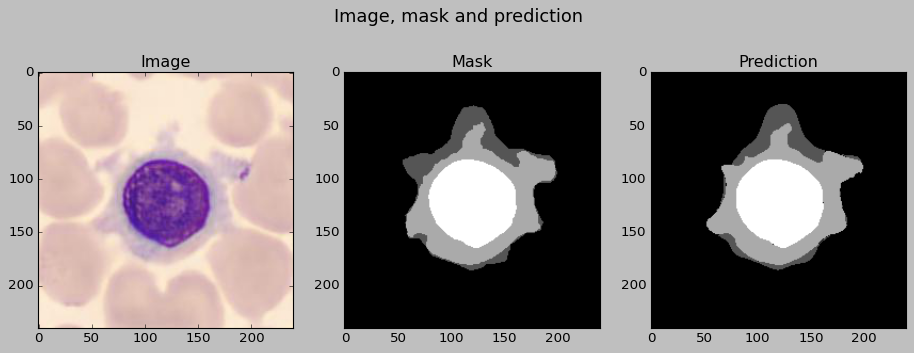

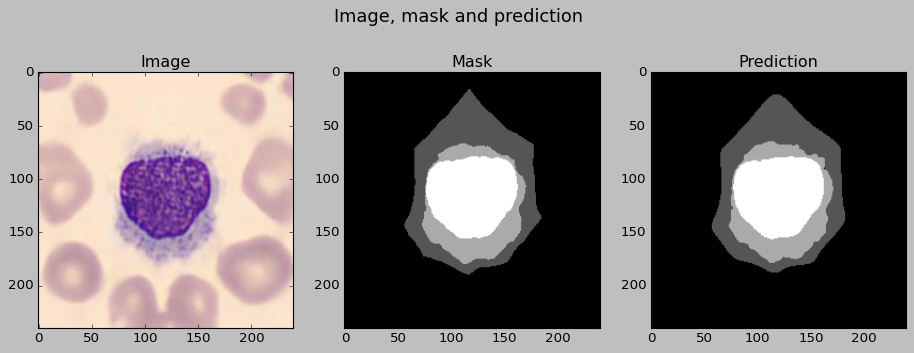

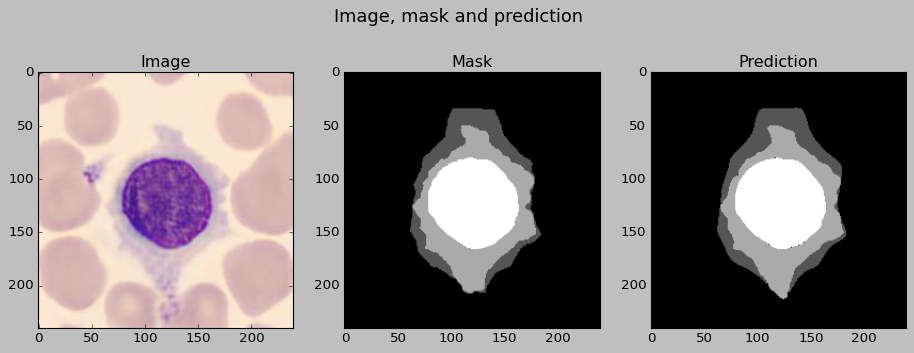

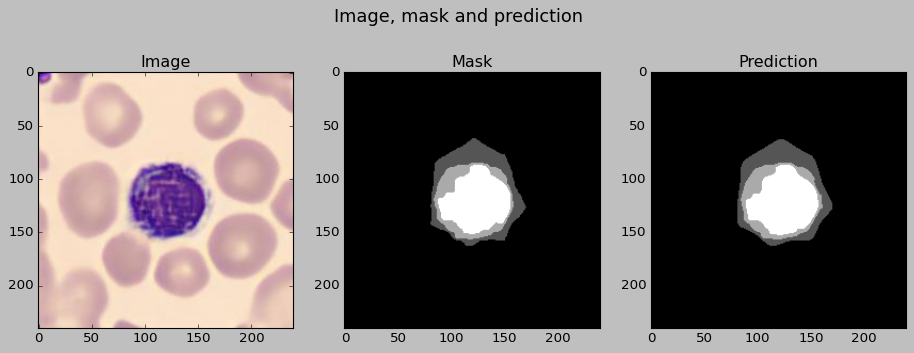

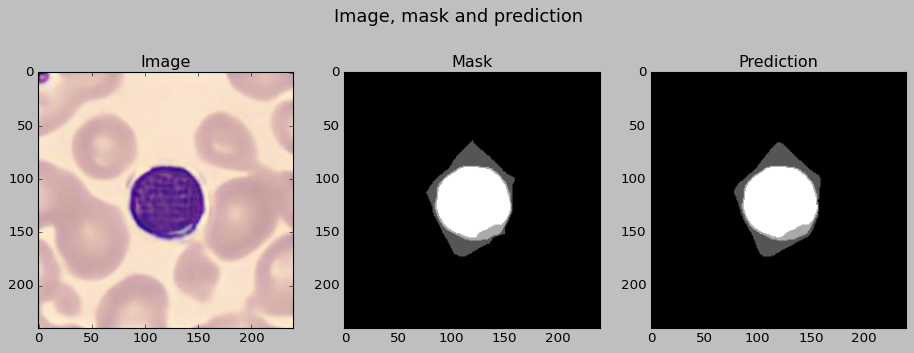

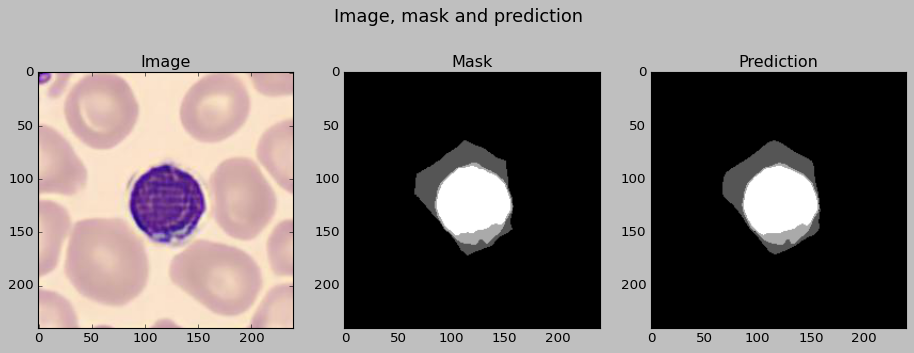

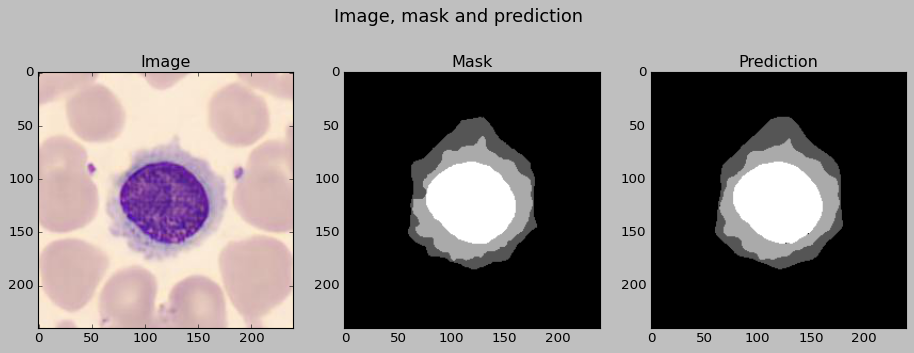

In [ ]:
# TODO: Complete the code

# View some results.
# Loop through all images of this batch
for i in range(tbs):
    # Image
    im = to_npimage(inputs[i])

    # Original mask
    msk = flatten_mask(to_npimage(masks[i]))

    # Predicted mask
    prd = flatten_mask(to_npimage(pred[i].detach()))

    # Show comparison
    show_compare(im, msk, prd)

### Dice coefficient in test

The dice coefficient in test dataset, with the given example model, is about 95%. Probably, with the VGG16Unet it will be a little bit higher.

In [ ]:
# Run the test
test_metrics = do_test(dataloaders['test'], model, lf=1)

# Show dice coefficient on test dataset
print('\n\nDice coefficient: {:.2f}%'.format(100 * test_metrics['test_dice']))



Dice coefficient: 96.32%


## Assesment

Deliver this notebook with the results of the executed cells. The notebook **must include in this last cell a link** where I can download the VGG16Unet model that you have designed.

I hope you've learned a lot and you've enjoyed this final lab.

Link: https://drive.google.com/file/d/1IgRD61sy6i1M5IOX6TpfwzpgRYz0-eu1/view?usp=sharing

In [ ]:
model

VGG16UNet(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     